In [1]:
# Following the article @ https://towardsdatascience.com/anova-test-with-python-cfbf4013328b

In [44]:
import numpy as np
np.random.seed(2023 - 7 - 12)
import pandas as pd
from scipy.stats import (t, norm, f)
import matplotlib.pyplot as plt

# ___Analysis of Variance (ANOVA)___
---------------

In [2]:
# ANOVA is carried out to compare a given statistic across a number of populations.

In [3]:
# Let's say that we have a gigantic population of graduates. Which inclused graduates from a number of fields;
# e.g. Biology, Medicine, Vetenary Science, Social Science, Law, Business, Marketting etc..

# If we consider the graduates from each of these fields as formulating separate populations, and we study samples from such populations to make
# inferences about the populations;

In [4]:
students = pd.read_csv("./students.csv", low_memory = False, memory_map = True).query("graduated == 1")
students.shape

(1753, 16)

In [5]:
students.head()

,stud.id,name,gender,age,height,weight,religion,nc.score,semester,major,minor,score1,score2,online.tutorial,graduated,salary
11,200803,"Lang, Mackenzie",Female,22,162,66.8,Other,1.04,4th,Economics and Finance,Environmental Sciences,62.0,61.0,1,1,45254.108021
13,354271,"Covar Orendain, Christopher",Male,23,185,84.6,Orthodox,1.00,4th,Environmental Sciences,Mathematics and Statistics,71.0,76.0,1,1,40552.790243
14,317812,"Lopez, Monique",Female,20,158,64.4,Catholic,2.50,6th,Environmental Sciences,Social Sciences,66.0,70.0,1,1,27007.030294
17,350040,"Hines, Haileigh",Female,22,156,61.7,Other,2.27,6th,Political Science,Biology,57.0,54.0,0,1,33969.159268
28,763393,"Woolsey, Bronson",Male,24,182,80.1,Protestant,1.09,5th,Economics and Finance,Social Sciences,61.0,73.0,1,1,50617.641870


In [6]:
students.major.unique(), students.major.unique().size

(array(['Economics and Finance', 'Environmental Sciences',
        'Political Science', 'Mathematics and Statistics', 'Biology',
        'Social Sciences'], dtype=object),
 6)

In [7]:
students.columns

Index(['stud.id', 'name', 'gender', 'age', 'height', 'weight', 'religion',
       'nc.score', 'semester', 'major', 'minor', 'score1', 'score2',
       'online.tutorial', 'graduated', 'salary'],
      dtype='object')

In [11]:
# We have graduates from 6 different fields.

students.groupby("major").agg({"major": np.size, "salary": [np.nanmean, np.nanstd, lambda salary: salary.std() / np.sqrt(salary.size)]})

major        salary                         
                            size       nanmean       nanstd  <lambda_0>
major                                                                  
Biology                      330  47942.830314  8816.127264  485.311833
Economics and Finance        295  49696.171910  8495.624305  494.634370
Environmental Sciences       345  37652.678362  5709.916421  307.411566
Mathematics and Statistics   288  48443.506902  8355.358883  492.344244
Political Science            289  36390.273276  9221.790894  542.458288
Social Sciences              206  32044.006106  6204.670006  432.299844

In [65]:
8816.127264 / np.sqrt(1597)

220.61010060811344

In [66]:
# Our question here is, is there a significant difference in the earnings by graduates from the 6 populations?
# Our sample sizes are;

students.groupby("major").size()

major
Biology                       330
Economics and Finance         295
Environmental Sciences        345
Mathematics and Statistics    288
Political Science             289
Social Sciences               206
dtype: int64

## ___Normality Check___
-----------------

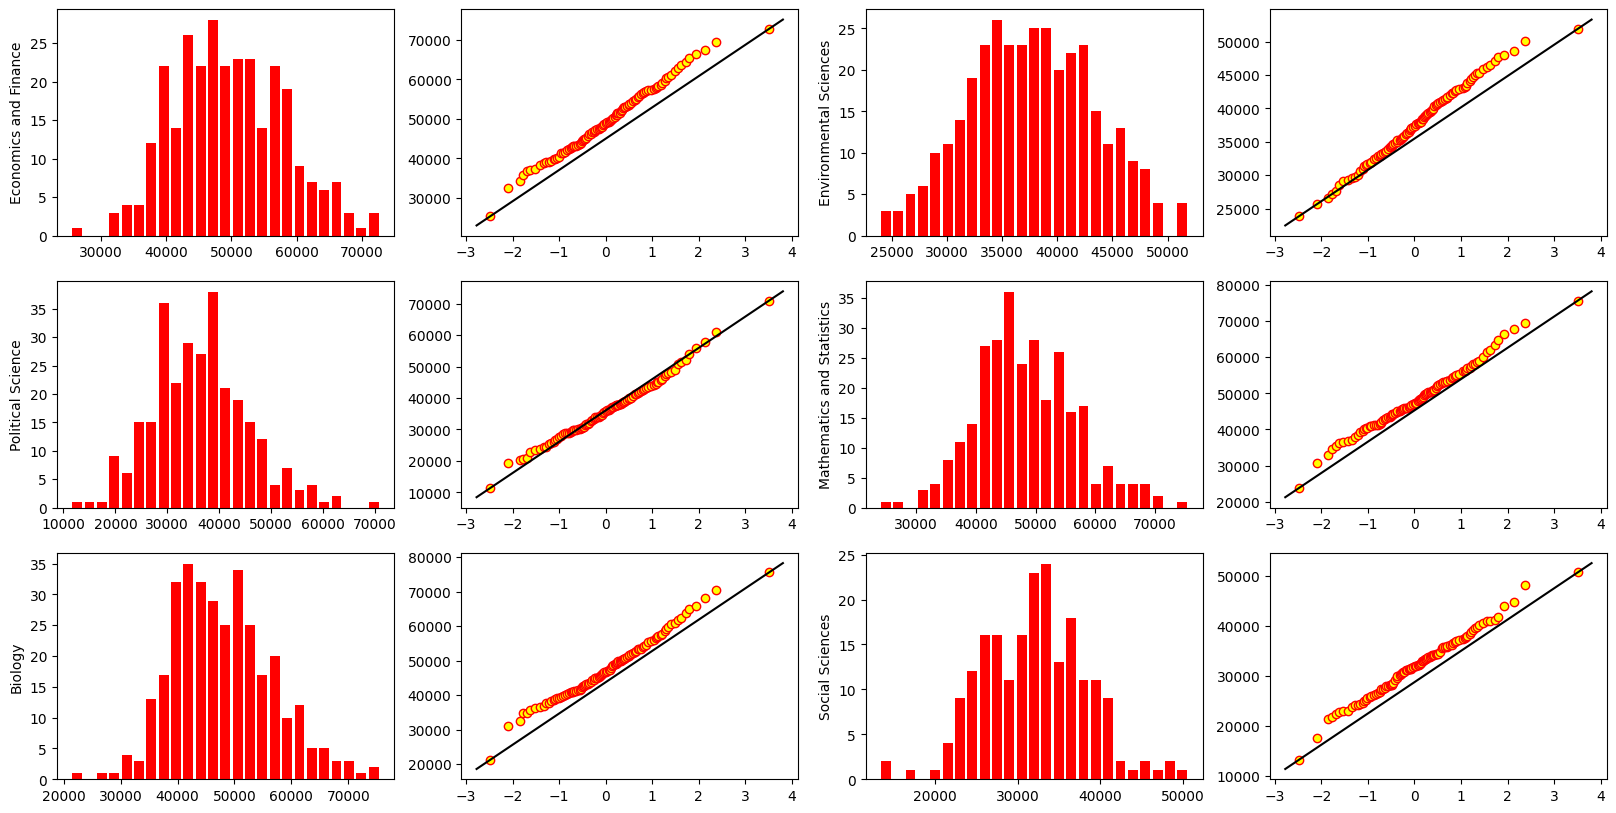

In [13]:
q = np.linspace(0, 1, num = 100, endpoint = True)
qnorm = np.quantile(a = norm.rvs(size = 1000), q = q)

fig, ((axes_0, axes_1, axes_2, axes_3), (axes_4, axes_5, axes_6, axes_7), (axes_8, axes_9, axes_10, axes_11)) = plt.subplots(nrows = 3, ncols = 4)
fig.set_size_inches(20, 10)
axes = ((axes_0, axes_1), (axes_2, axes_3), (axes_4, axes_5), (axes_6, axes_7), (axes_8, axes_9), (axes_10, axes_11))

for (major, (hisaxes, qqaxes)) in zip(students.major.unique(), axes):

    salary = students.salary[students.major == major]
    
    hisaxes.hist(salary, bins = 25, rwidth = 0.8, color = "red")
    hisaxes.set_ylabel(major)
    
    qqaxes.scatter(qnorm, np.quantile(salary, q = q), color = "yellow", edgecolor = "red")
    qqaxes.plot(qqaxes.get_xbound(), qqaxes.get_ybound(), color = "black", marker = "none")

plt.show()

In [68]:
# Hypothesis tests:

### ___$H_0: \mu_{Economics~and~Finance} = \mu_{Environmental~Sciences} = \mu_{Political Science} = \mu_{Mathematics~and~Statistics} = \mu_{Biology} = \mu_{Social Sciences}$___
### ___$H_1: Mean~salaries~of~graduates~with~the~6~are~not~equal!$___

In [15]:
# The sum of squared differences in the whole feature.

sum_of_squared_differences = lambda array: ((array - array.mean()) ** 2).sum()

In [16]:
ss_total = sum_of_squared_differences(students.salary)
ss_total

187067663098.91522

In [21]:
# Sum of squared differences within groups.

ss_groups = students.groupby("major").agg({"salary": [sum_of_squared_differences, np.mean], "stud.id": np.size})
ss_groups

salary               stud.id
                              <lambda_0>          mean    size
major                                                         
Biology                     2.557123e+10  47942.830314     330
Economics and Finance       2.121964e+10  49696.171910     295
Environmental Sciences      1.121548e+10  37652.678362     345
Mathematics and Statistics  2.003605e+10  48443.506902     288
Political Science           2.449193e+10  36390.273276     289
Social Sciences             7.892076e+09  32044.006106     206

In [20]:
# Sum of squared differences between groups.

global_mean = students.salary.mean()
global_mean

42522.112364224806

In [34]:
ss_between = (ss_groups["stud.id"]["size"].values * (ss_groups["salary"]["mean"].values - global_mean) ** 2).sum()
ss_between

76641259228.17558

In [35]:
ss_within = ss_groups["salary"]["<lambda_0>"].values.sum()
ss_within

110426403870.73967

In [42]:
# See how these two are same!

ss_between + ss_within, ss_total

(187067663098.91525, 187067663098.91522)

In [43]:
fstat = (ss_between / (6 - 1)) / (ss_within / (students.size - 6))
fstat

3892.500554110644

In [48]:
p = 2 * (1 - f.cdf(fstat, dfn = 5, dfd = students.size - 6))
p

2.220446049250313e-16

In [49]:
students.size - 6

28042

In [50]:
# p value is less than the significance level of 0.05,
# We'll reject the Null hypothesis.

# There indeed is a statsitically significant difference between the variances of the six different groups.